# Explore Sales Prices for São Paulo

In this file, we will combine the latest ITBI Transactions, explore the prices, and then merge the previous years' data onto the latest file to conduct a comprehensive time series analysis.

Main Objective:

The primary goal of this analysis was to explore and prepare the real estate transaction data for Sao Paulo. We aimed to clean the data, identify and handle outliers, and create a dataset suitable for further analysis and visualization, particularly for integration into a Power BI dashboard.

Our goals are as follows:

- Create a file that can be seamlessly integrated into the Power BI Dashboard for dynamic visualization.
- Explore the Price Per Square Metre after applying our pre-determined adjustments to ensure accuracy.
- Examine the date ranges for our 2024 dataframe to verify its relevance and completeness.
- Link the pre-generated shapefile of São Paulo neighborhoods to provide geographical context.
- Additionally, we will implement robust data cleaning methods to remove outliers and ensure the integrity of our dataset, focusing on maintaining valuable information from top-selling and more expensive neighborhoods.

In [1]:
#Read General libraries
import pandas as pd
import numpy as np
import datetime as dt
import scipy.stats as stats
import geopandas as gpd
# Read libraries for visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
# View all columns in large datasets
pd.set_option("display.max_columns",None)

## Read and Combine all excel files

In [2]:
itbi_latest=pd.read_excel(r"P:\Brazil States\Data Source\SP\ITBI Transactions\transactions 2024.xlsx", 
                          sheet_name=None, dtype={'N° do Cadastro (SQL)': str})
itbi_latest.keys()
all_2024= pd.concat(itbi_latest, ignore_index=True).copy()

In [3]:
print(all_2024.shape)
print(all_2024.info())

(61138, 29)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61138 entries, 0 to 61137
Data columns (total 29 columns):
 #   Column                                            Non-Null Count  Dtype         
---  ------                                            --------------  -----         
 0   N° do Cadastro (SQL)                              61138 non-null  object        
 1   N° do Cadastro (text)                             61138 non-null  object        
 2   Nome do Logradouro                                61138 non-null  object        
 3   Número                                            61138 non-null  int64         
 4   Complemento                                       54747 non-null  object        
 5   Bairro                                            37863 non-null  object        
 6   Referência                                        26502 non-null  object        
 7   CEP                                               61138 non-null  int64         
 8   Natureza de Tr

# Preparation of data

- Check the missing values
- Check the duplications
- Check and format data types
- Make sure there's no irregularlities

## Missing Values

In [4]:
for column in all_2024.columns:
    if all_2024[column].isna().mean() != 0:
        print("=======================================================")
        print(f"{column} ==> Missing Values: {all_2024[column].isna().mean()}, Data Type: {all_2024[column].dtypes}")

Complemento ==> Missing Values: 0.10453400503778337, Data Type: object
Bairro ==> Missing Values: 0.3806961300664071, Data Type: object
Referência ==> Missing Values: 0.5665216395694985, Data Type: object
Tipo de Financiamento ==> Missing Values: 0.577594949131473, Data Type: object
ACC (IPTU) ==> Missing Values: 0.17707481435441133, Data Type: float64


### Complete the missing text columns

The bairro, reference and complement columns will be filled with unknown. When we produce visualisation tables, the data is presented better when it's not NaN.

In [5]:
def fill_missing_text(df, complement, bairro, reference):
    if df[complement].isna().any() or df[bairro].isna().any() or df[reference].isna().any():
        all_2024[complement] = df[complement].fillna("Unknown")
        all_2024[bairro] = df[bairro].fillna("Unknown")
        all_2024[reference] = df[reference].fillna("Unknown")        

In [6]:
fill_missing_text(all_2024, 'Complemento', 'Bairro', 'Referência')

### Convert values to Numbers

In [7]:
all_2024['Valor Financiado']=pd.to_numeric(all_2024['Valor Financiado'],errors='raise')
all_2024['ACC (IPTU)']=pd.to_numeric(all_2024['ACC (IPTU)'],errors='raise')

We now should only see missing values in the year built column.

In [8]:
for column in all_2024.columns:
    if all_2024[column].isna().mean() != 0:
        print("=======================================================")
        print(f"{column} ==> Missing Values: {all_2024[column].isna().mean()}, Data Type: {all_2024[column].dtypes}")

Tipo de Financiamento ==> Missing Values: 0.577594949131473, Data Type: object
ACC (IPTU) ==> Missing Values: 0.17707481435441133, Data Type: float64


## Duplicates

In [9]:
all_2024.duplicated().sum()

146

In [10]:
all_2024.drop_duplicates(keep='first',inplace=True)

## Format and structure

We need to rename the columns into English and make the dataset more practical so that we can perform our analysis at the end of the process. Morever, the dataset needs to be useable so that it can be added to our Power BI system so that visualisations can be presented to the Brazilian press and various other stakeholders in the business.

In [11]:
all_2024 = all_2024.rename(columns={'N° do Cadastro (SQL)': 'sql', 'N° do Cadastro (text)':'property_no',
                                  'Nome do Logradouro': 'street_name', 
                                  'Número': 'house_number', 
                                  'Complemento': 'unit_ref',
                                  'Bairro': 'neighborhood_tr', 
                                  'Referência': 'building_ref', 
                                  'CEP': 'postcode', 
                                  'Natureza de Transação': 'transaction_type',
                                  'Valor de Transação (declarado pelo contribuinte)': 'sale_price', 
                                  'Data de Transação': 'date_sold',
                                  'Valor Venal de Referência': 'reference_market_value', 
                                  'Proporção Transmitida (%)': 'pct_transferred',
                                  'Valor Venal de Referência (proporcional)': 'proportional_market_value', 
                                  'Base de Cálculo adotada': 'tax_base_adopted',
                                  'Tipo de Financiamento': 'financing_type', 
                                  'Valor Financiado': 'financing_value', 
                                  'Cartório de Registro': 'registry_office',
                                  'Matrícula do Imóvel': 'property_reg', 
                                  'Situação do SQL': 'sql_status', 
                                  'Área do Terreno (m2)': 'land_area',
                                  'Testada (m)':'frontage', 
                                  'Fração Ideal': 'ideal_fraction', 
                                  'Área Construída (m2)': 'built_area', 
                                  'Uso (IPTU)': 'use_id',
                                  'Descrição do uso (IPTU)': 'use_description', 
                                  'Descrição do padrão (IPTU)':'construction_standard_sales',
                                  'Padrão (IPTU)':'construction_id', 
                                  'ACC (IPTU)': 'construction_year',
})

### Fix Financing Value

In [12]:
all_2024['financing_type'].value_counts()

financing_type
1.Sistema Financeiro de Habitação    20497
2.Minha Casa Minha Vida               4748
3.Consórcio                            555
99.SFI, Carteira Hipotecária, etc       10
Name: count, dtype: int64

In [13]:
all_2024['financing_type'].isna().mean()

0.5768297481636936

In [14]:
# Fill the missing values and mark 0s cash sales.

def financing_value_cleaned(financing_value, financing_type):
    if pd.isna(financing_type) and financing_value > 0:
        return "Unknown Financing"
    elif pd.isna(financing_type) and financing_value == 0:
        return "Cash Sale"
    else:
        return financing_type

In [15]:
# Test
print(financing_value_cleaned(0,np.nan))
print(financing_value_cleaned(100000,np.nan))
print(financing_value_cleaned(150000,"1.Sistema Financeiro de Habitação"))
print(financing_value_cleaned(150000,np.nan))

Cash Sale
Unknown Financing
1.Sistema Financeiro de Habitação
Unknown Financing


### Convert Date Formats
Convert date formats and add the year of sale column.

In [16]:
all_2024['date_sold'] = pd.to_datetime(all_2024['date_sold'], format='%Y-%m-%d %H:%M:%S',errors='raise')
all_2024['year_sold'] = pd.DatetimeIndex(all_2024['date_sold']).year
all_2024['month_sold'] = pd.PeriodIndex(all_2024['date_sold'],freq='M')

In [17]:
all_2024['date_sold'].max()

Timestamp('2024-05-07 00:00:00')

In [18]:
all_2024.info()

<class 'pandas.core.frame.DataFrame'>
Index: 60992 entries, 0 to 61137
Data columns (total 31 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   sql                          60992 non-null  object        
 1   property_no                  60992 non-null  object        
 2   street_name                  60992 non-null  object        
 3   house_number                 60992 non-null  int64         
 4   unit_ref                     60992 non-null  object        
 5   neighborhood_tr              60992 non-null  object        
 6   building_ref                 60992 non-null  object        
 7   postcode                     60992 non-null  int64         
 8   transaction_type             60992 non-null  object        
 9   sale_price                   60992 non-null  float64       
 10  date_sold                    60992 non-null  datetime64[ns]
 11  reference_market_value       60992 non-null  f

In [19]:
all_2024['sale_price'] = pd.to_numeric(all_2024['sale_price'],errors='raise')
all_2024['reference_market_value'] = pd.to_numeric(all_2024['reference_market_value'],errors='raise')
all_2024['proportional_market_value'] = pd.to_numeric(all_2024['proportional_market_value'],errors='raise')
all_2024['tax_base_adopted'] = pd.to_numeric(all_2024['tax_base_adopted'],errors='raise')

In [20]:
all_2024['sale_price'].describe()

count    6.099200e+04
mean     6.209753e+05
std      2.902600e+06
min      1.000000e-02
25%      2.350000e+05
50%      3.181464e+05
75%      5.400000e+05
max      5.150000e+08
Name: sale_price, dtype: float64

#### Translate Property Type

In [21]:
all_2024['use_description_en']=all_2024['use_description'].replace({'ARMAZÉNS GERAIS E DEPÓSITOS':'Warehouses and Storage',
                                               'APARTAMENTO EM CONDOMÍNIO (EXIGE FRAÇÃO IDEAL)':'Apartment', 
                                               'LOJA': 'Retail Property',
                                               'TERRENO':'Land/Plot', 
                                               'RESIDÊNCIA':'Casa',
                                               'ESCRITÓRIO/CONSULTÓRIO EM CONDOMÍNIO (UNID AUTÔNOMA EXIGE FRAÇÃO IDEAL)':'Office/Clinic',
                                               'GARAGEM (UNIDADE AUTÔNOMA) EM EDIFÍCIO EM CONDOMÍNIO DE USO EXCLUSIVAMENTE RESIDENCIAL (EXIGE FRAÇÃO IDEAL)':'Garage (Independent Unit)',
                                               'FLAT RESIDENCIAL EM CONDOMÍNIO (EXIGE FRAÇÃO IDEAL)':'Flat (residential)',
                                               'OUTRAS EDIFICAÇÕES DO TIPO, COM UTILIZAÇÃO MÚLTIPLA':'Other Mixed-used buildings',
                                               'RESIDÊNCIA COLETIVA, EXCLUSIVE CORTIÇO (MAIS DE UMA RESIDÊNCIA NO LOTE)':'Townhouse/Collective Residence',
                                               'LOJA EM EDIFÍCIO EM CONDOMÍNIO (UNIDADE AUTÔNOMA EXIGE FRAÇÃO IDEAL)':'Retail Property',
                                               'GARAGEM (UNIDADE AUTÔNOMA) EM EDIFÍCIO EM CONDOMÍNIO DE ESCRITÓRIOS, CONSULTÓRIOS OU MISTO (EXIGE FRAÇÃO IDEAL)':'Garage (Independent Unit)',
                                               'OFICINA':'Workshop', 
                                               'RESIDÊNCIA E OUTRO USO (PREDOMINÂNCIA RESIDENCIAL)': 'Miscellanous Residential',
                                               'LOJA E RESIDÊNCIA (PREDOMINÂNCIA COMERCIAL)':'Retail Property', 
                                               'INDÚSTRIA':'Industrial',
                                               'TEMPLO':'Religious',
                                               'FLAT DE USO COMERCIAL (SEMELHANTE À HOTEL)':'Flat (Commerical)',
                                               'PRÉDIO DE ESCRITÓRIO OU CONSULTÓRIO, NÃO EM CONDOMÍNIO, COM OU SEM LOJAS':'Office/Clinic',
                                               'PRÉDIO DE APARTAMENTO, NÃO EM CONDOMÍNIO, DE USO EXCLUSIVAMENTE RESIDENCIAL':'Apartment',
                                               'GARAGEM (UNIDADE AUTÔNOMA) DE PRÉDIO DE GARAGENS (EXIGE FRAÇÃO IDEAL)':'Garage (Independent Unit)',
                                               'ESCOLA':'School',
                                               ' ':'Unknown',
                                               'OUTRAS EDIFICAÇÕES DO TIPO COM UTILIZAÇÃO MÚLTIPLA':'Other Mixed-used buildings',
                                               'POSTO DE SERVIÇO':'Service station',
                                               'ESTAÇÃO RADIOEMISSORA, DE TELEVISÃO OU EMPRESA JORNALÍSTICA':'Media Property',
                                               'HOSPITAL, AMBULATÓRIO, CASA DE SAÚDE E ASSEMELHADOS':'Hospital/Clinic/Health Centre',
                                               'GARAGEM (EXCLUSIVE EM PRÉDIO EM CONDOMÍNIO)':'Garage (condo exlusive)',
                                               'PRÉDIO DE APARTAMENTO, NÃO EM CONDOMÍNIO, DE USO MISTO (APARTAMENTOS E ESCRITÓRIOS E/OU CONSULTÓRIOS), COM OU SEM LOJA (PREDOMINÂNCIA RESIDENCIAL)':'Mixed-use Apartments',
                                               'CINEMA, TEATRO, CASA DE DIVERSÃO, CLUBE OU CONGÊNERE':'Entertainment venue',
                                               'HOTEL, PENSÃO OU HOSPEDARIA':'Hotel',
                                               'CORTIÇO (HABITAÇÃO COLETIVA SUBNORMAL) ':'Subnormal housing/Cortico',
                                               'PRÉDIO COM USO MISTO, PREDOMINÂNCIA DE USO NÃO RESIDENCIAL, NÃO EM CONDOMÍNIO':'Mixed-use Non-residential',
                                               'ASILO, ORFANATO, CRECHE, SEMINÁRIO OU CONVENTO ':'Social care facility'
})

In [22]:
all_2024['use_description_en'].value_counts()

use_description_en
Apartment                         21688
Land/Plot                         10814
Casa                               8274
Garage (Independent Unit)          3718
Office/Clinic                      3272
Retail Property                    2814
Other Mixed-used buildings         2014
Townhouse/Collective Residence     1737
Industrial                         1633
Warehouses and Storage             1171
School                              945
Flat (Commerical)                   603
Garage (condo exlusive)             533
Miscellanous Residential            495
Unknown                             285
Hotel                               233
Workshop                            222
Mixed-use Apartments                189
Flat (residential)                  121
Subnormal housing/Cortico            84
Hospital/Clinic/Health Centre        48
Service station                      45
Religious                            34
Social care facility                 10
Entertainment venue  

## Add some new columns

The next step is to enrich our data and to add some additional columns that will help with our analysis and visualisation. We will add a catagory for the year of construction, adjust the built area in order to create a living area column and then calculate the price per square metre based on the living area. We will also need to be careful to avoid errors in the ppsqm calculation and make a adjustment to ensure we use the correct value for land plots.

In [23]:
def adjusted_square_metres(row):
    if (
        row['use_description'] in [
            "APARTAMENTO EM CONDOMÍNIO (EXIGE FRAÇÃO IDEAL)",
            "PRÉDIO DE APARTAMENTO, NÃO EM CONDOMÍNIO, DE USO EXCLUSIVAMENTE RESIDENCIAL",
            "FLAT RESIDENCIAL EM CONDOMÍNIO (EXIGE FRAÇÃO IDEAL)",
        ]
    ):
        if row['built_area'] >= 200:
            return row["built_area"] * 0.6
        elif row["built_area"] >= 100:
            return row["built_area"] * 0.7
        else:
            return row["built_area"] * 0.8
    elif (
        row['use_description']
        in [
            "RESIDÊNCIA COLETIVA, EXCLUSIVE CORTIÇO (MAIS DE UMA RESIDÊNCIA NO LOTE)",
            "RESIDÊNCIA",
            "RESIDÊNCIA E OUTRO USO (PREDOMINÂNCIA RESIDENCIAL)",
        ]
    ):
        if row['construction_standard_sales'] == "RESIDENCIAL VERTICAL":
            if row["built_area"] >= 200:
                return row['built_area'] * 0.6
            elif row['built_area'] >= 100:
                return row['built_area'] * 0.7
            else:
                return row['built_area'] * 0.8
        else:
            return row['built_area']
    else:
        return row['built_area']

In [24]:
all_2024["adjusted_built_area"] = all_2024.apply(adjusted_square_metres, axis=1)

In [25]:
all_2024['adjusted_built_area'].describe()

count     60992.000000
mean       1144.360142
std        7526.430551
min           0.000000
25%          34.400000
50%          79.100000
75%         168.000000
max      164615.000000
Name: adjusted_built_area, dtype: float64

## Add Price per square metre column

Although, this will be adjusted based on pre-defined metrics that take into account the living area of a property.

In [26]:
checking_sqm = all_2024[all_2024['adjusted_built_area'] == 0]
checking_sqm['use_description'].value_counts()

use_description
TERRENO    10814
Name: count, dtype: int64

In [27]:
def price_per_square_metre(row):
    if row['adjusted_built_area'] > 0:
        return row['sale_price'] / row['adjusted_built_area']
    else: return  row['sale_price'] / row['land_area']

In [28]:
all_2024['price_per_square_metre'] = all_2024.apply(price_per_square_metre, axis=1)

In [29]:
all_2024['price_per_square_metre'].describe().astype('int')

count     60992
mean       3865
std       10089
min           0
25%         310
50%        2781
75%        5560
max      734422
Name: price_per_square_metre, dtype: int32

When we have a ppsqm as 0, it is because the sales price is 0 and by using our ppsqm function, we remove the infinity values when there properties are classified as land. Therefore, we can comfortably say that our calculation is correct.

We can see from the distribution of price and price per square metre that there are a high proportion of outliers in our dataset, therefore in order to create our visualisation tables, we will need to filter our dataset to ensure that we're only taking relevant data for relavant properties, relevant years and for prices that are practical and inline with the market.

# Feature Exploration

## Understanding Price per Square Metre

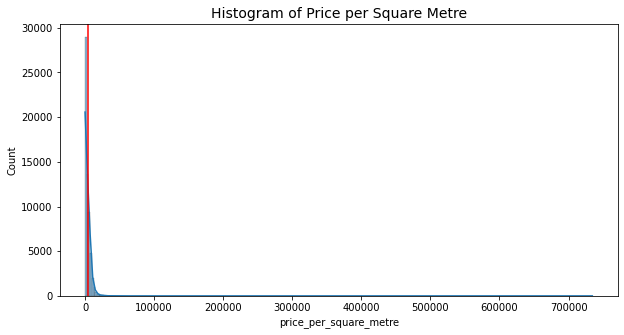

In [30]:
mean_ppsqm=np.mean(all_2024['price_per_square_metre'])

fig, ax = plt.subplots(figsize=(10,5))

sns.histplot(data=all_2024, x='price_per_square_metre', bins=300, kde=True, ax=ax)
plt.axvline(mean_ppsqm, color='r', linestyle='-', linewidth=1.5)

title = f'Histogram of Price per Square Metre'
ax.set_title(title, fontsize=14)
plt.show()

So, as we can tell from the ppsqm values there are a significant number of outliers in our dataframe. Next will be produce a table by transaction type with the min, max and average and standard deviation to see where our outliers may be.

In [31]:
prices_by_type=all_2024.groupby('transaction_type').agg({'price_per_square_metre': ['min','mean','max','std','median','count']}).reset_index()
prices_by_type.sort_values(by=('price_per_square_metre',  'count'),ascending=False)

transaction_type price_per_square_metre  \
                                                                         min   
0                                    1.Compra e venda           4.252346e-07   
3         12.Dação em pagamento por escritura pública           1.188340e+00   
10        20.Realização ou integralização de capital            7.182761e-05   
7   17.Resolução da alienação fiduciária por inadi...           4.671111e+00   
25         4.Arrematação (em leilão ou hasta pública)           1.697389e+00   
9   2.Cessão de direitos relativos a compromisso d...           1.351351e-04   
5                    15.Permuta por escritura pública           3.279592e+00   
27                          5.Adjudicação compulsória           6.535948e-05   
18  29.Excesso de meação na partilha (separação / ...           1.516596e+00   
22               33.Demais atos onerosos translativos           4.807692e-03   
19  3.Adjudicação (vinculada a processo de execuçã...           1.470588e-02   
15  26.Cessão de direitos sobre o imóvel com alien...           4.302326e+00   
29  8.Cessão de direitos hereditários (ou sucessór...           4.740834e+01   
24  35.Demais transações de direitos de compromiss...           7.142857e-05   
26            40.Excesso na integralização de capital           2.660857e+01   
23                      34.Demais sentenças judiciais           1.391965e+01   
12                          23.Cisão total ou parcial           1.000000e-03   
11                                    21.Incorporação           1.030928e+03   
16  27.Excesso de quinhão ou quota-parte na divisã...           3.750000e+00   
20  30.Excesso de meação na partilha (dissolução d...           5.061867e+00   
17  28.Excesso de meação ou quinhão na partilha (s...           3.489453e+00   
14  25.Desincorporação do bem imóvel pertencente à...           1.980588e+00   
8                                         19.Usufruto           5.061867e+02   
13                     24.Extinção de pessoa jurídica           4.444315e+02   
2                 11.Cessão de direitos de superfície           4.024145e+01   
21             31.Rejeição dos embargos à arrematação           2.026667e+03   
28         5.Excesso de meação ou quinhão na partilha           1.547448e+01   
1               10.Cessão dos direitos do arrematante           1.178279e+03   
30             9.Cessão dos direitos do adjudicatário           1.874774e+01   
4                         14.Mandato em causa própria           2.656969e+01   
6                                          16.Remição           2.917528e+03   

                                                                  
           mean            max           std       median  count  
0   3954.068004  734422.225000  10543.512741  2828.805522  55143  
3   3184.185481   35204.895210   4061.774502  1614.635714   1519  
10  2825.182464   49466.638421   3836.280769  1235.466667   1062  
7   4446.271957   25650.557621   2365.500180  4066.905208    719  
25  3280.749607   24257.587576   2626.747521  2913.083590    510  
9   2363.999799   19230.769231   3151.847340  1162.790698    429  
5   3787.235557   20008.181452   3622.447165  2777.777778    353  
27  2312.293807   13322.818727   2180.796159  1796.789474    183  
18  1677.467488    9342.640417   1490.749468  1322.290226    180  
22  1997.363232   21640.246376   4594.617837     7.399120    164  
19  3610.092283   69012.790865   6124.380857  3050.450732    156  
15  2092.621677   11204.481793   1723.611673  1717.245573    147  
29  1426.653326   10135.135135   1680.171324   807.102502     99  
24   857.043419    3928.571429    552.368217   771.236735     73  
26  2632.178479   13031.674208   2472.163272  2083.333333     57  
23  1506.258327    5781.586271   1292.265308  1155.462185     44  
12  2109.453071   23036.649215   4316.671404   841.603771     31  
11  4766.973745   13233.318400   2639.027176  3799.915663     24  
16   973.059096    5450.070323   1325.525601   418.12666

When we look at transactions for our key type with with are property purchases (type 1), we can see that they will have the highest number of outliers compared to other others, with a standard deviation of 10,000 and a maximum price of 734,422. 

Let's now look at the distribution for price per square metre of only regular purchases.

### Only Sales Price per Square Metre

The IQR = 5419.13955687461
The Mean = 3954.0680040466927
The Median = 2828.8055223880597
The Standard Deviation=10543.417138584804


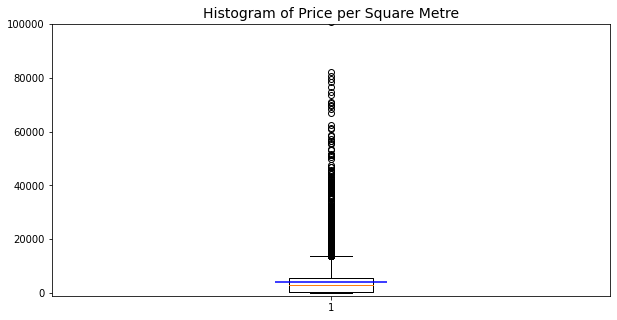

In [32]:
only_sales=all_2024.query("transaction_type == '1.Compra e venda'")

mean_salesppsqm=np.mean(only_sales['price_per_square_metre'])
median_salesppsqm=np.median(only_sales['price_per_square_metre'])
std_salesppsqm=np.std(only_sales['price_per_square_metre'])

# Printing the key boxplot statistics
Q1 = only_sales['price_per_square_metre'].quantile(0.25)
Q3 = only_sales['price_per_square_metre'].quantile(0.75)
IQR = Q3 - Q1
print(f"The IQR = {IQR}\nThe Mean = {mean_salesppsqm}\nThe Median = {median_salesppsqm}\nThe Standard Deviation={std_salesppsqm}")

# Producing the chart
fig, ax = plt.subplots(figsize=(10,5))
plt.boxplot(only_sales['price_per_square_metre'])
plt.hlines(y=mean_salesppsqm, xmin=0.9, xmax=1.1, color='blue')
plt.ylim(-1000, 100000) # set the range for the vertical axis
title = f'Histogram of Price per Square Metre'
plt.title(title, fontsize=14)
plt.show()

Even with just the sales prices as we saw in the summary table we can see that there is a high variance in the price per square metre in our dataframe. Prices are flying above 5000 where the majority of properties sit. In Sao Paulo luxury properties tend to have a price from 9,000 to 15,000 in the apartment market housing from 3,000 to 10,000.

## Year of Sale

Now, we check all our transactions are from the correct period as we downloaded the file for 2024, all our transactions should from the year 2024. As you can see below, the transaction years are mixed up.

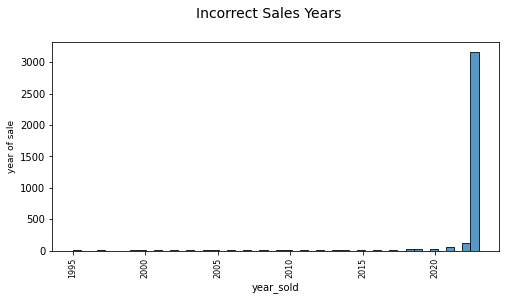

In [33]:
fig, ax = plt.subplots(figsize=(8, 4))
incorrect_years=all_2024.query("year_sold < 2024")
ax = sns.histplot(incorrect_years, x='year_sold',bins=50)
ax.set_ylabel("year of sale", fontsize=9, color='black')
ax.yaxis.label.set_color('black')
title = 'Incorrect Sales Years'
fig.suptitle(title, y=.97, fontsize=14)
plt.subplots_adjust(top=0.85)

plt.xticks(rotation=90, fontsize=8)
plt.show()

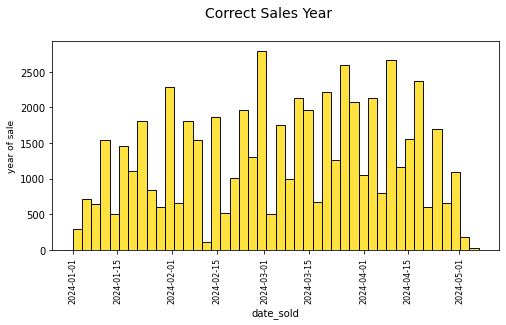

In [34]:
fig, ax = plt.subplots(figsize=(8, 4))
correct_year=all_2024.query("year_sold == 2024")
ax = sns.histplot(correct_year, x='date_sold',bins='auto',color='gold')
ax.set_ylabel("year of sale", fontsize=9, color='black')
ax.yaxis.label.set_color('black')
title = 'Correct Sales Year'
fig.suptitle(title, y=.97, fontsize=14, color='black')
plt.subplots_adjust(top=0.85)

plt.xticks(rotation=90, fontsize=8)
plt.show()

## Percentage Transferred 

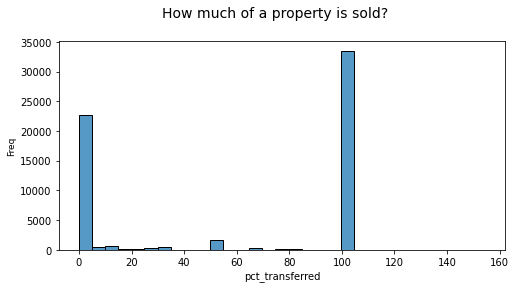

In [35]:
fig, ax = plt.subplots(figsize=(8, 4))
ax = sns.histplot(all_2024, x='pct_transferred',bins='auto')
ax.set_ylabel("Freq", fontsize=9, color='black')
ax.yaxis.label.set_color('black')
title = 'How much of a property is sold?'
fig.suptitle(title, y=.97, fontsize=14)
plt.subplots_adjust(top=0.85)

In [36]:
mean_pct=np.mean(all_2024['pct_transferred'])
median_pct=np.median(all_2024['pct_transferred'])
std_pct=np.std(all_2024['pct_transferred'])

pctQ1 = all_2024['pct_transferred'].quantile(0.25)
pctQ3 = all_2024['pct_transferred'].quantile(0.75)
pct_IQR = pctQ3 - pctQ1
print(f"The IQR = {pct_IQR}\nThe Mean = {mean_pct}\nThe Median = {median_pct}\nThe Standard Deviation={std_pct}")

The IQR = 99.74
The Mean = 57.908718356505766
The Median = 100.0
The Standard Deviation=47.72066554621583


Another factor that could be influencing our prices and outliers is the percentage transfer. If we are going to be looking to smoothen the prices, we would need to find only arms length deals. Therefore, to progress, we would want to look at properties with 100 as the value in the percentage transferred column.

## Price Exploration by type of asset

Now we will look at the price exploration by type of asset. We will use all our previous filters, taking into account the correct years, percentage transferred and the property types.

### First main filtering using property types and transfer types

In [37]:
# Split to relevant buildings
rel_buildings=all_2024[all_2024['construction_standard_sales'].isin(['RESIDENCIAL HORIZONTAL ','RESIDENCIAL VERTICAL',
                                                       'COMERCIAL VERTICAL','COMERCIAL HORIZONTAL'])]

res_props=rel_buildings[(rel_buildings['use_description_en'].isin(["Apartment","Casa","Flat (residential)",
                                                                   "Townhouse/Collective Residence"])) & 
                        (rel_buildings['pct_transferred']==100) & (rel_buildings['year_sold'] == 2024)
                       &(rel_buildings['transaction_type'] == '1.Compra e venda')].copy()

The IQR = 4127.016707021792
The Mean = 6582.066701732819
The Median = 5614.884453781513
The Standard Deviation=6640.923885926035


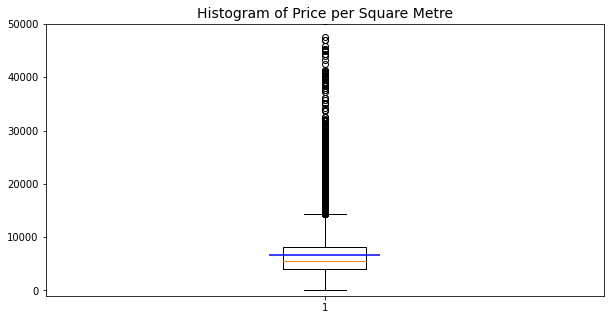

In [38]:
mean_res=np.mean(res_props['price_per_square_metre'])
median_res=np.median(res_props['price_per_square_metre'])
std_res=np.std(res_props['price_per_square_metre'])

priceQ1 = res_props['price_per_square_metre'].quantile(0.25)
priceQ3 = res_props['price_per_square_metre'].quantile(0.75)
price_IQR = priceQ3 - priceQ1
print(f"The IQR = {price_IQR}\nThe Mean = {mean_res}\nThe Median = {median_res}\nThe Standard Deviation={std_res}")

fig, ax = plt.subplots(figsize=(10,5))
plt.boxplot(res_props['price_per_square_metre'])
plt.hlines(y=mean_res, xmin=0.9, xmax=1.1, color='blue')
plt.ylim(-1000, 50000)
title = f'Histogram of Price per Square Metre'
plt.title(title, fontsize=14)
plt.show()

Compared to our previous results on the ppsqm, we can see that the statistics are higher and our standard deviation is significantly lower when we only look at residential properties.

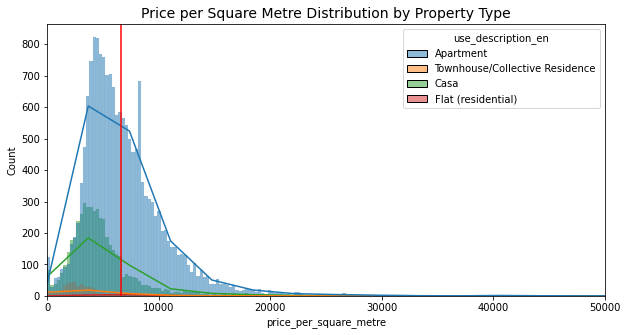

In [39]:
fig, ax = plt.subplots(figsize=(10,5))

sns.histplot(data=res_props, x='price_per_square_metre', hue='use_description_en', bins='auto', kde=True, ax=ax)
plt.axvline(mean_res, color='r', linestyle='-', linewidth=1.5)
plt.xlim(0, 50000)
title = f'Price per Square Metre Distribution by Property Type'
ax.set_title(title, fontsize=14)
plt.show()

The distribution shows the majority of prices below the mean price for all properties and below the 10,000 range. The median is around 1k lower than the mean. Although, we can see the number of luxury properties is lower with a significant 10,000 and only a few over the 20,000 market.

# Neighbourhoods

In [40]:
neighbourhoods=gpd.read_parquet(r"P:\Brazil States\Data Source\SP\Estado\Bairros\Estado bairros\sp_bairros_all.parquet")

# Link the geometry
lots=gpd.read_parquet(r"P:\Brazil States\Processed\qgis\SP\dissolved-lots-saop.parquet")
lots.drop(columns=['lot','sql','lo_tp_quad','lo_tp_lote'],inplace=True)
lots['sector_block']=(lots['sector'] + lots['block']).astype('str')

# Add linking column for geometry - We are using the filtered dataframe "res_props" from above.
res_props['property_no'] = res_props['property_no'].str.rsplit('-', n=1).str[0]
res_props['property_no']=res_props['property_no'].str.replace('-','').astype('str')
res_props['sl'] = res_props['property_no'].str[:6].astype('str')

test_file=pd.merge(res_props, lots, left_on='sl',
                    right_on='sector_block',how='left')

gdf=gpd.GeoDataFrame(test_file,geometry='geometry')

gdf.drop(columns=['sl', 'sector','block', 'condo','neighborhood_tr'],inplace=True)
gdf.rename(columns={'neighborho':'bairro_official'},inplace=True)
gdf.dropna(subset='bairro_official',inplace=True)

In [41]:
print(test_file.duplicated().sum())

0


## Exploration by Neighbourhood

1) Understand where the most sales have occurred

2) What is the distribution of sales prices in the top 5 areas (by sales) and how does it different from all prices?

In [42]:
excluding_may=gdf[gdf['month_sold']!='2024-05']
top_sellers_2024=pd.pivot_table(excluding_may, index='bairro_official',columns='month_sold',values='property_no',aggfunc='count')
top_sellers_2024['total_sales']=top_sellers_2024.sum(axis=1)
top10_2024=top_sellers_2024.sort_values(by='total_sales',ascending=False).head(10)
top10_2024

month_sold,2024-01,2024-02,2024-03,2024-04,total_sales
bairro_official,,,,,
VILA MARIANA,116.0,151.0,141.0,169.0,577.0
PINHEIROS,120.0,125.0,154.0,141.0,540.0
BELA VISTA,93.0,107.0,122.0,118.0,440.0
INDIANOPOLIS,90.0,78.0,118.0,121.0,407.0
AGUA BRANCA - BARRA FUNDA,82.0,78.0,127.0,119.0,406.0
VILA OLYMPIA,28.0,35.0,36.0,303.0,402.0
SANTO AMARO,70.0,82.0,113.0,118.0,383.0
PERDIZES,70.0,78.0,93.0,115.0,356.0
BROOKLIN,68.0,87.0,104.0,93.0,352.0


The top sellers across the city of Sao Paulo in May 2024 were Vila Mariana, Pinheiros and Bela Vista. These are the hotest markets according to the City Hall's ITBI Register of recorded sales.

In [43]:
top_10_sellers=gdf[gdf['bairro_official'].isin(['VILA MARIANA', 'PINHEIROS', 'BELA VISTA', 'INDIANOPOLIS',
                                             'AGUA BRANCA - BARRA FUNDA', 'VILA OLYMPIA', 'SANTO AMARO', 
                                             'PERDIZES','BROOKLIN', 'JARDIM PAULISTA'])]

The IQR = 4127.016707021792
The Mean = 9596.199249655814
The Median = 8567.415730337078
The Standard Deviation=4557.161302835138


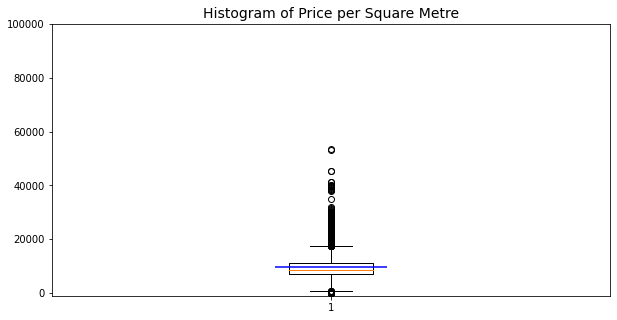

In [44]:
mean_top_price=np.mean(top_10_sellers['price_per_square_metre'])
median_top_price=np.median(top_10_sellers['price_per_square_metre'])
std_top_price=np.std(top_10_sellers['price_per_square_metre'])

toppriceQ1 = top_10_sellers['price_per_square_metre'].quantile(0.25)
toppriceQ3 = top_10_sellers['price_per_square_metre'].quantile(0.75)
topprice_IQR = priceQ3 - priceQ1
print(f"The IQR = {topprice_IQR}\nThe Mean = {mean_top_price}\nThe Median = {median_top_price}\nThe Standard Deviation={std_top_price}")

fig, ax = plt.subplots(figsize=(10,5))
plt.boxplot(top_10_sellers['price_per_square_metre'])
plt.hlines(y=mean_top_price, xmin=0.9, xmax=1.1, color='blue')
plt.ylim(-1000, 100000) # set the range for the vertical axis
title = f'Histogram of Price per Square Metre'
plt.title(title, fontsize=14)
plt.show()

## Analysis of Top 10 Sellers against all Residential:

<b>Mean Comparison:</b>

The mean price per square meter for the top 10 neighborhoods is significantly higher (9596.19) compared to the overall mean. This indicates that the top neighborhoods are much more expensive on average.

<b>Median  Comparison:</b>

The median price per square meter for the top 10 neighborhoods is also much higher (8567.41) than the overall median. This suggests that the typical (middle) price in the top neighborhoods is much higher than the typical price in the general market.

<b>Standard Deviation:</b>

The standard deviation is lower for the top 10 neighborhoods (4557.16) compared to the overall market (6640.92). This indicates that prices in the top 10 neighborhoods are less dispersed around the mean compared to the general market.

<b>Summary:</b>

The top 10 neighborhoods exhibit much higher mean and median prices per square meter, indicating that these areas are significantly more expensive. The lower standard deviation in the top 10 neighborhoods suggest less variability in prices, indicating a more stable and homogeneous price range compared to the broader market. Overall, the top neighborhoods not only command higher prices but also display more consistent pricing.

# Feature Relationships

To further analyze and understand the trends in your real estate data, the next step is to create a correlation matrix. This matrix will help identify the relationships between different variables, such as price per square meter, neighborhood characteristics, and other relevant factors. 

Begin by ensuring your dataset is clean and free of inconsistencies. For instance, we will only be using the features that we are familiar with and that are relevant: these include the area of the property, area of the land, property type, construction type and the location.  

This will provide insights into how different variables are related, potentially revealing key factors that influence real estate prices.

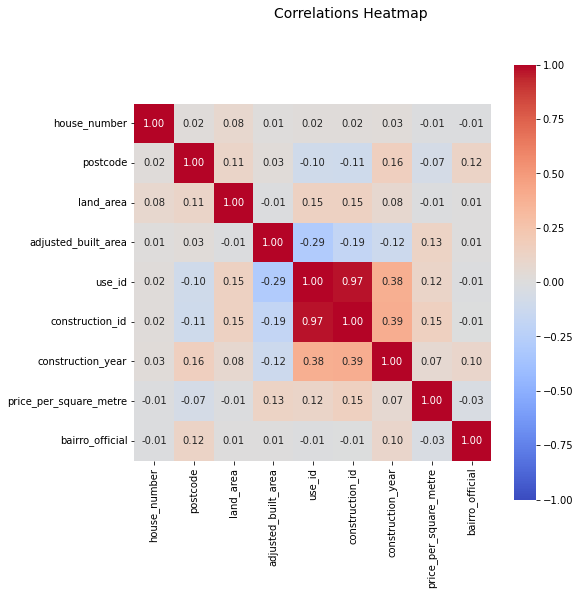

In [45]:
corr_table=gdf[['property_no','street_name','house_number','unit_ref','date_sold',
                'postcode','land_area','adjusted_built_area','use_id','construction_id',
                'construction_year','price_per_square_metre','bairro_official']].copy()
le = LabelEncoder()
le.fit(corr_table['bairro_official'])
corr_table['bairro_official'] = le.transform(corr_table['bairro_official'])

# Build matrix table
corr_table_numeric = corr_table.select_dtypes(include=[np.number])
corr_matrix=corr_table_numeric.corr()
fig, ax = plt.subplots(1,1, figsize=(8,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', square=True,vmin=-1, vmax=1)
title = 'Correlations Heatmap'
fig.suptitle(title, fontsize=14)
plt.show()

In [46]:
print(corr_matrix['price_per_square_metre'])

house_number             -0.008385
postcode                 -0.066588
land_area                -0.009865
adjusted_built_area       0.131369
use_id                    0.116199
construction_id           0.152829
construction_year         0.069893
price_per_square_metre    1.000000
bairro_official          -0.032741
Name: price_per_square_metre, dtype: float64


## Analysis

Price Per Square Meter Correlation:

- Property Area: Correlation coefficient is 0.131369. This indicates a low positive correlation, suggesting that larger built areas are associated with higher prices per square meter. Which is as expected and portrays accuracies in our data.

- Use ID: Correlation coefficient is 0.116199. This shows a low positive correlation, indicating some positive effect of the usage category of the property on the price per square meter. It's likely that there will be higher prices for apartments and flats compared to larger properties and houses.

- Construction Year: Correlation coefficient is 0.069893. This indicates a low positive correlation, implying that newer buildings may have a slightly higher price per square meter. 

- Construction ID: Correlation coefficient is 0.152829. This indicates a low positive correlation, suggesting a slight relationship between construction classification and price per square meter. This indications that the construction quality has a slight positive impact on our property prices.

- Land Area: Correlation coefficient is -0.01368. This shows a very low negative correlation, suggesting almost no relationship between land area and price per square meter.

- Postcode: Correlation coefficient is -0.009865. This indicates a low negative correlation, implying that the postcode has a slight negative impact on the price per square meter. This may be better looked at when looking at detached homes separately.

- Bairro Official: Correlation coefficient is -0.032741. This indicates a very low negative correlation, suggesting little to no impact of the official neighborhood designation on price per square meter.

### How the construction year impacts the price per square metre?

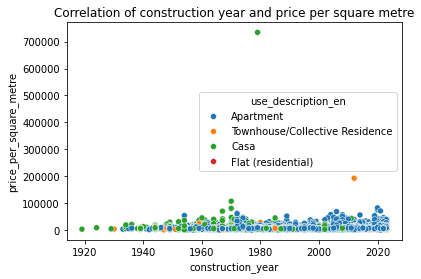

In [47]:
sns.scatterplot(data=gdf, x='construction_year', y='price_per_square_metre', hue='use_description_en')
plt.title('Correlation of construction year and price per square metre')
plt.show()

Immediately, we can see that a large number of propeties are below 100000 which is expected, however, there is a significant outlier in the dataset at 700000 per square metre, which is highly irregular and requires further investigation. Moreover, when cleaning through our dataset we will likely consider BRL 100000-200000/m2 as too high and will cut off prices within the bracket.

Price Distribution:

- The majority of the properties have prices per square meter below 100,000 BRL, which is expected in a typical market.
- There is a significant outlier at approximately 700,000 BRL per square meter, which is highly irregular.
- The outlier at 700,000 BRL per square meter should be investigated further to understand if it's due to data entry errors, special circumstances, or genuinely reflects a unique property.

Data Cleaning:

- Considering the typical range of prices, it is reasonable to identify properties priced between 100,000 and 200,000 BRL per square meter as potentially too high and outliers.
- These outliers can distort the analysis, so setting a reasonable cutoff for price per square meter is a valid approach.

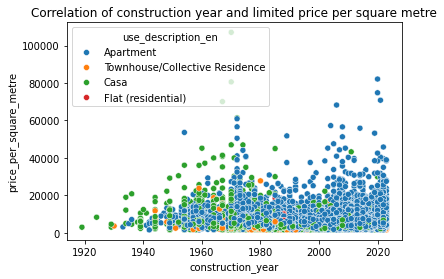

In [48]:
ppsqm_limits=gdf[(gdf['price_per_square_metre']<=150000) & (gdf['price_per_square_metre']>=1500)]
sns.scatterplot(data=ppsqm_limits, x='construction_year', y='price_per_square_metre', hue='use_description_en')
plt.title('Correlation of construction year and limited price per square metre')
plt.show()

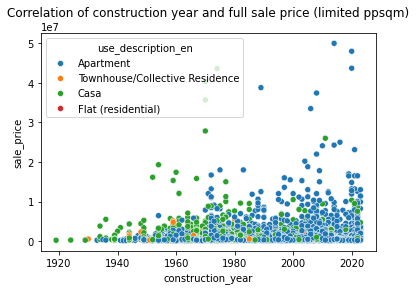

In [49]:
sns.scatterplot(data=ppsqm_limits, x='construction_year', y='sale_price', hue='use_description_en')
plt.title('Correlation of construction year and full sale price (limited ppsqm)')
plt.show()

Now that we have places limits on the price per square metre, we can see the following:
- Positive correlation as expected as properties get more modern.
- The majority of the properties are priced below BRL 20000.
- There are a high number of outliers in the House category that were constructed in the 1960s-1970s.
- Apartments construction in the 2020s have significant outliers.

Positive Correlation: There is a general positive correlation between construction year and price per square meter, indicating that newer properties tend to have higher prices per square meter. This is expected as newer properties often come with modern amenities and better construction standards.

Price Distribution: The majority of the properties are priced below 20,000 BRL per square meter. This indicates that most properties fall within a reasonable and expected price range for the market.

<b>Category-Specific Outliers:</b>

- House (Casa): There are a significant number of outliers for houses constructed in the 1960s-1970s. These outliers may need further investigation to determine if they are due to historical value, renovations, or data errors. In a similiar pattern there are full sales prices that surpass BRL 10,000,000, which may explain the high ppsqm as properties may have had smaller areas at this time, which could be something interesting to look at separately. 
- Apartments (Apartment): Properties constructed in the 2020s also show significant outliers. This could be due to new developments in prime locations, luxury apartments, or pricing anomalies that should be examined.

<b>What to investigate?</b>

1) Further analyze the outliers in the house category from the 1960s-1970s to understand the reasons behind their high prices.

2) Similarly, investigate the outliers among apartments constructed in the 2020s to determine if they are due to specific high-value properties or data issues.

### 1960-1970 House Sales

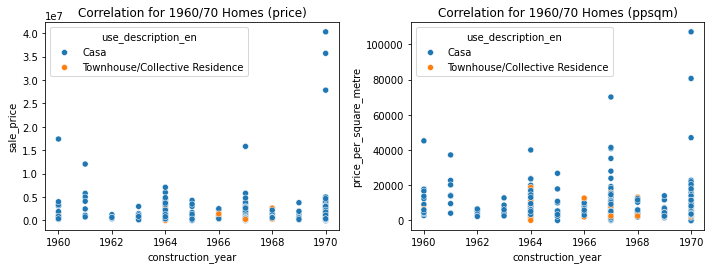

In [50]:
homes_outliers=gdf[(gdf['construction_year']>=1960) & (gdf['construction_year']<=1970)&
                   (gdf['use_description_en'].isin(['Casa','Townhouse/Collective Residence']))]

fig, ax = plt.subplots(1,2, figsize=(10,4))
sns.scatterplot(data=homes_outliers, x='construction_year', y='sale_price', hue='use_description_en',ax=ax[0])
ax[0].set_title('Correlation for 1960/70 Homes (price)')
sns.scatterplot(data=homes_outliers, x='construction_year', y='price_per_square_metre', hue='use_description_en',ax=ax[1])
ax[1].set_title('Correlation for 1960/70 Homes (ppsqm)')
plt.tight_layout()
plt.show()

### Properties from 2020s

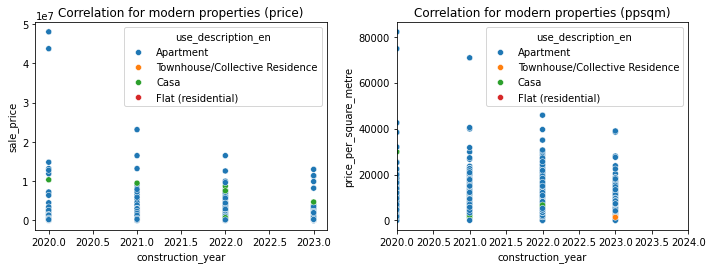

In [51]:
modern_outliers=gdf[gdf['construction_year']>=2020]

fig, ax = plt.subplots(1,2, figsize=(10,4))
sns.scatterplot(data=modern_outliers, x='construction_year', y='sale_price', hue='use_description_en',ax=ax[0])
ax[0].set_title('Correlation for modern properties (price)')
sns.scatterplot(data=modern_outliers, x='construction_year', y='price_per_square_metre', hue='use_description_en',ax=ax[1])
ax[1].set_title('Correlation for modern properties (ppsqm)')

plt.xlim(2020,2024)
plt.tight_layout()
plt.show()

### Area vs. Year of Construction

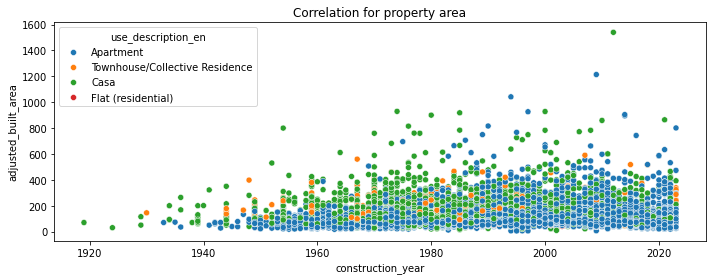

In [52]:
fig, ax = plt.subplots(figsize=(10,4))
sns.scatterplot(data=gdf, x='construction_year', y='adjusted_built_area', hue='use_description_en')
plt.title('Correlation for property area')
plt.tight_layout()
plt.show()

## Conclusion:
Based on our exploration, it is clear that significant outliers exist in our house prices. After careful analysis, we can now determine how to filter our data effectively to remove these outliers without losing key properties in top-selling and more expensive neighborhoods.

### New Cleaning Methods

<b>Full Sales Price:</b>

Filter properties with a sale price between >150,000 BRL and <15,000,000 BRL.
Price per Square Meter (ppsqm):

Filter properties with a price per square meter between >1,500 BRL and <150,000 BRL.

Property Area (after adjustment):

For Apartments/Flats:
- Filter properties with a size between >19 sqm and <1,000 sqm.

For Houses (Casas):
- Filter properties with a size between >70 sqm and <10,000 sqm.

These filtering methods will help remove outliers while retaining valuable data for properties in top-selling and expensive neighborhoods, leading to more accurate and reliable analysis.

Additionally, we will incorporate the methods from earlier which included:
- pct_transferred being 100%
- year_sold being 2024
- transaction_type being '1.Compra e venda' 

Following from our cleaning methods, we will produce a month price trend across the city of sao paulo and re-evaluate and compare the Top 10 Sellers to our pre-cleaned table.

# Final Trends and Price Analysis

In [53]:
gdf['transaction_type'].value_counts()

transaction_type
1.Compra e venda    22825
Name: count, dtype: int64

In [54]:
data_new = gdf[(gdf['adjusted_built_area']>19) & (gdf['adjusted_built_area']<10000) &
                    (gdf['sale_price']>150000) & (gdf['sale_price']<15000000) &
                    (gdf['price_per_square_metre']>1500) & (gdf['price_per_square_metre']<150000)
                   ].copy()

In [55]:
def size_filter(row):
    if row['use_description_en'] == 'Land/Plot':
        return 0
    elif row['use_description_en'] == "Casa":
        if row['adjusted_built_area'] < 10000 and row['adjusted_built_area'] > 70:
            return row['adjusted_built_area']
        else:
            return np.nan
    elif row['use_description_en'] == "Apartment":
        if row['adjusted_built_area'] > 19 and row['adjusted_built_area'] < 1000:
            return row['adjusted_built_area']
        else:
            return np.nan
    else:
        return row['adjusted_built_area']
        
data_new['adjusted_built_area'] = data_new.apply(size_filter, axis=1)
data_new.dropna(subset='adjusted_built_area',inplace=True)

# Quick PowerBI Format Export

The below is a quick way for me to export all the data so that I can incorporate into Power BI quickly and add to my visualisation pipeline.

In [ ]:
path=r"P:\Brazil States\Processed\Power BI\SP\ITBI Transactions Cleaned January to April 2024.xlsx"

data_new.to_excel(path,index=False,sheet_name='2024 transactions')

# General Conclusion for the Sao Paulo Real Estate Data Analysis

## Key Steps and Findings:

### Data Cleaning:

- We started by combining the latest ITBI transactions with previous years' data to create a comprehensive time series dataset.

- Missing values and inconsistent entries were addressed, ensuring data quality and reliability.

### Outlier Identification and Handling:

- Significant outliers in the dataset were identified, particularly in the price per square meter (ppsqm) and sale price columns.

- We established thresholds to filter out extreme values: prices per square meter between 1,500 and 150,000 BRL, and sale prices between 150,000 and 15,000,000 BRL.

- Property size filters were applied: for apartments/flats, sizes between 19 and 1,000 square meters; for houses (Casas), sizes between 70 and 10,000 square meters.

### Price Per Square Meter Analysis:

- After applying the filters, we analyzed the price per square meter, revealing a general positive correlation between construction year and price, as expected.
- The majority of properties were priced below 20,000 BRL per square meter, with notable outliers in certain categories and years that warranted further investigation.

### Category-Specific Insights:

- Houses (Casas) constructed in the 1960s-1970s showed a high number of outliers, possibly due to historical value or data inconsistencies.
- Apartments constructed in the 2020s had significant outliers, likely reflecting new developments in prime locations or luxury properties.

### Data Preparation for Visualization:

The cleaned and filtered dataset was prepared for visualization, with particular attention to creating a file suitable for integration into a Power BI dashboard.
A linkage with the pre-generated shapefile of Sao Paulo neighborhoods was established to provide geographical context for the analysis.

### Next Steps:

Further Analysis:

- Continue exploring the dataset to identify trends and patterns, particularly focusing on the identified outliers to understand their causes and implications.

Visualization:

- Develop comprehensive visualizations using the cleaned dataset to provide clear insights into the real estate market trends in Sao Paulo.

- Integration:
Integrate the prepared dataset into the Power BI dashboard to enable dynamic and interactive data exploration for stakeholders.

Conclusion:

This analysis has laid a solid foundation for understanding the real estate market in Sao Paulo. By meticulously cleaning the data and handling outliers, we have ensured that the dataset is reliable and ready for in-depth analysis and visualization. These efforts will significantly contribute to informed decision-making and strategic planning in the real estate sector.